In [21]:
import os
import torch.nn.functional as F
import torch
from torch.utils.tensorboard import SummaryWriter
from torch import optim
from sklearn import metrics
import numpy as np
import cv2
import sys
sys.path.append('../../')
from config import *
from PE_helper import *
from file_helper import *
from horizon_utlis import *
from Horizon_DataLoader import *

#======= [ SETTING ] =======
MAX_PREDICTION_COUNT = Horizon_MAX_PREDICTION
BATCH_SIZE=2
C = Horizon_C
R = Horizon_R
CONFIDENCE_THRESHOLD = Horizon_CONFIDENCE_THRESHOLD
DO_AUG= Horizon_AUG

#MODEL_FOLDER =r'./output/'
MODEL_FOLDER = create_folder( os.path.join(os.getcwd() , "output" , "checkpoints" ))

#LONAD_MODEL_NAME ="n90-c0.1-r10-0912-all-final-save.pth"  
LONAD_MODEL_NAME =""  
TRAIN_NAME = f"__0.35loss"
writer = SummaryWriter(TRAIN_NAME)

TRAIN_DATASET_NAME  = "../../anno/train_visiable_20_no_cross.json"
TEST_DATASET_NAME   = "../../anno/test_visiable_10_no_cross.json"

#========= [ Log Setting ] ==========
MAX_LOG_GAP = 5
MAX_LOG_IT_COUNT = 5
EVAL_GAP = 5
save_auc = 0.2
log_folder = create_folder( os.path.join(os.getcwd() , "output" , TRAIN_NAME ))

In [22]:
#======= [ Load Model ] =======
from horizon_model_direct import HorizonNet
def create_model(load_pth = ""):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    net = HorizonNet('resnet50', True , MAX_PREDICTION_COUNT).to(device)   # For server (small memory)

    if (load_pth is not "" or None):              
        model_path = os.path.join(MODEL_FOLDER , load_pth)
        state_dict = torch.load(model_path, map_location='cpu')
        
        # model data
        net.load_state_dict(state_dict['state_dict'])
        LOADED_EPOCH    = state_dict['epoch']
        LOADED_AP       = state_dict['ap']
        save_auc        = LOADED_AP  
        print( LOADED_EPOCH , LOADED_AP)
    return net

#model = create_model(LONAD_MODEL_NAME)
model = HorizonNet('resnet50', True , MAX_PREDICTION_COUNT).to(device) 
opt = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=0.0035,
        betas=(0.9, 0.999))

In [23]:
# Dataloader

'''Test
dataset = CustomDataset( f"../../anno/test_visiable_10_no_cross.json"  , use_aug= False )     
dataloader = DataLoader(dataset, 2 , shuffle=False, drop_last =True)
data = next(iter(dataloader))     
visualize_2d(     
	data['u'],
	data['v_top'],
	data['v_btm'],
	data['image'],
	data['u_grad'],
)
'''

'Test\ndataset = CustomDataset( f"../../anno/test_visiable_10_no_cross.json"  , use_aug= False )     \ndataloader = DataLoader(dataset, 2 , shuffle=False, drop_last =True)\ndata = next(iter(dataloader))     \nvisualize_2d(     \n\tdata[\'u\'],\n\tdata[\'v_top\'],\n\tdata[\'v_btm\'],\n\tdata[\'image\'],\n\tdata[\'u_grad\'],\n)\n'

In [24]:
from tqdm import tqdm
from torchvision import ops
MAX_LOG_GAP = 5
def train_loop( dataloader , ep_count = 0  , log_folder ="", device = 'cuda'):
    
    it_count = 0    
    model.train()
    for data in tqdm(dataloader , desc="ep "+str(ep_count) , ):       

        for k, v in data.items():    
            data[k]=data[k].to(device)       
            
        pack_gt = (data['u'] , data['v_top'] , data['v_btm'] , data['du'] , data['dv_top'] , data['dv_btm'] , data['u_grad']  )        
        pack_gt = torch.cat(pack_gt , 1)
        b, _ = pack_gt.shape
        pack_gt = pack_gt.reshape((b,7,-1))
        #pack_gt = pack_gt.reshape((b,6,-1))
        pack_gt = encode(pack_gt)        
        
        #out = predict(data , model)   #[b , max_count , 5 ]
        out = model(data['image'])   #[b , max_count , 5 ]
        out = torch.transpose(out , 1 , 2) #[b , 5 , max_count ]        


        (matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) ,\
        (matched_prd_u , matched_prd_vtop ,matched_prd_vbtm , matched_prd_du ,matched_prd_dvtop , matched_prd_dvbtm,),gt_idxs  = match_gt(pack_gt , out )        

        losses = cal_loss(                
            (matched_prd_u , matched_prd_vtop ,matched_prd_vbtm , matched_prd_du ,matched_prd_dvtop , matched_prd_dvbtm,) ,         
            (matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) ,
            gt_idxs
        )        
        it_loss = sum(l for l in losses.values())              

        for k, v in losses.items():    
            writer.add_scalars('loss/'+k ,{'train':v.item()} , it_count + ep_count*len(dataloader))
        
        opt.zero_grad()
        it_loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0, norm_type='inf')
        opt.step()

        if((ep_count % MAX_LOG_GAP==0 ) and (it_count < 10)):            
            train_save_path = create_folder( os.path.join(log_folder , f"train_{ep_count}"))
            with torch.no_grad():                
                u,vt,vb,scores =  decode((matched_prd_u ,matched_prd_vtop ,matched_prd_vbtm , matched_prd_du ,matched_prd_dvtop , matched_prd_dvbtm), CONFIDENCE_THRESHOLD )
                plt_imgs = visualize_2d( 
                    u,
                    vt ,
                    vb , 
                    data['image'],
                    matched_prd_u,
                    #None,#u_grad
                    "Trainging Prediction",
                    True,
                    save_path=train_save_path
                
                )                
                u,vt,vb,scores =  decode((matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm),0.5 )
                plt_imgs = visualize_2d( 
                    u,
                    vt ,
                    vb , 
                    data['image'],
                    #None , #u_grad
                    data['u_grad'] ,
                    "GT",
                    save_path= train_save_path
                )
        it_count+=1        


def eval_loop( dataloader , ep_count ):  
    it_count    =0
    model.eval()

    pr_helper = PR_Eval_Helper(writer=writer ,ep= ep_count)
    #all_max_iou_pre_reg=[]
    #gt_count=0

    for data in tqdm(dataloader , desc="ep "+str(ep_count) , ):    
                
        for k, v in data.items():    
            data[k]=data[k].to(device)            
        
        pack_gt = (data['u'] , data['v_top'] , data['v_btm'] , data['du'] , data['dv_top'] , data['dv_btm'] , data['u_grad']  )        
        pack_gt = torch.cat(pack_gt , 1)
        b, _ = pack_gt.shape
        pack_gt = pack_gt.reshape((b,7,-1))
        pack_gt = encode(pack_gt)

        out = predict(data , model)   #[b , max_count , 6 ]
        out = torch.transpose(out , 1 , 2) #[b , 6 , max_count ]
        pack_out = (out[:,0] , out[:,1],out[:,2],out[:,3],out[:,4],out[:,5])

        # ====== Eval Loss ======
        (matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) ,\
        (matched_prd_u , matched_prd_vtop ,matched_prd_vbtm , matched_prd_du ,matched_prd_dvtop , matched_prd_dvbtm,),gt_idxs  = match_gt(pack_gt , out )

        losses = cal_loss(                
            (matched_prd_u , matched_prd_vtop ,matched_prd_vbtm , matched_prd_du ,matched_prd_dvtop , matched_prd_dvbtm,) ,         
            (matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) ,
            gt_idxs
        )        
        it_loss = sum(l for l in losses.values())              

        for k, v in losses.items():    
            writer.add_scalars('loss/'+k ,{'test' :v.item()} ,it_count + ep_count*len(dataloader))


        pred_u,pred_vt,pred_vb , pred_scores =  decode(pack_out , CONFIDENCE_THRESHOLD , True)                    
        gt_u,gt_vt,gt_vb,gt_u_grad =  decode((matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) , 0.5 , True)
        
        pred_poly = uv_to_distorted_box(pred_u,pred_vt,pred_vb)
        gt_poly = uv_to_distorted_box(gt_u,gt_vt,gt_vb)
      
        # ========= PR Curve ===========
        #for pred , gt ,score in zip(pred_bboxes , gt_bboxes , scores  ): # each image                                    
        for pred , gt  in zip(pred_poly , gt_poly ): # each image                                    
            pr_helper.eval_batch_pr(pred , gt , None , ep_count)

        #if((ep_count % MAX_LOG_GAP==0 ) and (it_count < MAX_LOG_IT_COUNT)):    
                
        if(it_count < MAX_LOG_IT_COUNT):        
            test_save_path = create_folder( os.path.join(log_folder , f"test_{ep_count}"))
            plt_imgs = visualize_2d( 
                pred_u,
                pred_vt ,
                pred_vb , 
                data['image'],
                #None,#u_grad,
                out[:,0],                
                "inf",
                True,
                pred_poly,
                save_path=test_save_path

            )
            '''
            for im in plt_imgs:
                #writer.add_image('vis/pred/eval-ep'+str(ep_count), im , dataformats="HWC")
                cv2.imwrite(log_folder+f"/inf-eval-ep{ep_count}-{it_count}.png" , im )
            '''

            plt_imgs = visualize_2d( 
                gt_u,
                gt_vt ,
                gt_vb , 
                data['image'],
                #None,
                data['u_grad'],
                "gt",
                False,
                gt_poly,
                save_path=test_save_path
            )
            '''
            for im in plt_imgs:
                #writer.add_image('vis/gt/eval-ep'+str(ep_count), im , dataformats="HWC")
                cv2.imwrite(log_folder+f"/gt-eval-ep{ep_count}-{it_count}.png" , im )
            '''
        '''
        if(it_count >2):
            break     
        '''        
        it_count +=1

    p , r ,auc = pr_helper.get_all_pr()
    #pr_helper.write_tensorboard()
    ap_50 = pr_helper.final_result_dict[1]['ap']   

    #return p , r ,auc
    return ap_50


'''
ep_count = 1
MAX_LOG_IT_COUNT=5

with torch.no_grad():                
    eval_loop(train_dataloader)
'''


'\nep_count = 1\nMAX_LOG_IT_COUNT=5\n\nwith torch.no_grad():                \n    eval_loop(train_dataloader)\n'

ep 0:   0%|          | 0/10 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ep 0:  10%|█         | 1/10 [00:00<00:06,  1.29it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ep 0:  20%|██        | 2

=========== EVAL =========


ep 0:   0%|          | 0/5 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ep 0:  20%|██        | 1/5 [00:00<00:02,  1.68it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ep 0:  40%|████      | 2/5

gt_count 19
all_prediction [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
recall [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158]
precision [1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.05555556 0.05263158 0.05       0.04761905 0.04545455 0.04347826
 0.04166667 0.04       0.03846154 0.03703704 0.03571429 0.03448276
 0.03333333]
ap_0.05 0.0014619883040935672
gt_count 19
all_prediction [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
recall [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

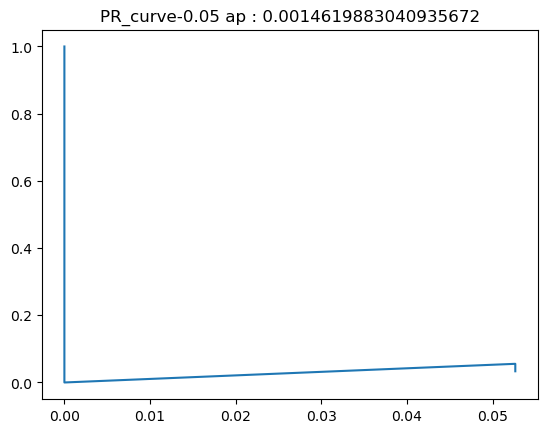

all_iou 0.1639486849308014
mIOU 0.008628878154252706


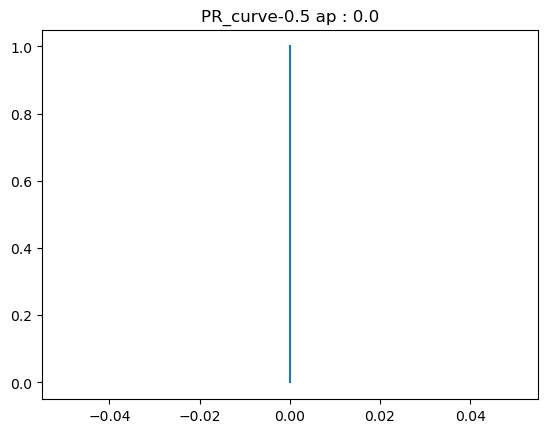

all_iou 0.1639486849308014
mIOU 0.008628878154252706


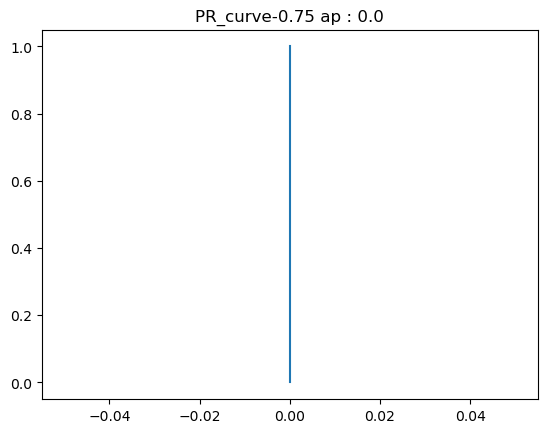

ep 5:   0%|          | 0/10 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ep 5:  10%|█         | 1/10 [00:00<00:07,  1.27it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ep 5:  20%|██        | 2

=========== EVAL =========


ep 5:   0%|          | 0/5 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ep 5:  20%|██        | 1/5 [00:00<00:02,  1.57it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ep 5:  40%|████      | 2/5

gt_count 19
all_prediction [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
recall [0.         0.         0.         0.         0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.10526316
 0.10526316 0.10526316 0.10526316 0.10526316 0.10526316 0.10526316
 0.10526316 0.10526316 0.15789474 0.15789474 0.21052632 0.21052632
 0.21052632 0.21052632 0.21052632 0.21052632 0.26315789 0.31578947
 0.31578947 0.31578947 0.36842105 0.36842105 0.42105263 0.42105263
 0.42105263 0.42105263 0.47368421 0.47368421 0.52631579 0.52631579
 0.52631579 0.52631579 0.52631579 0.52631579 0.57894737 0.57894737
 0.63157895 0.63157895 0.68421053 0.68421053 0.68421053 0.68421053
 0.73684211]
precision [1.         0.         0.         0.         0.25       0.2
 0.16666667 0.14285714 0.125 

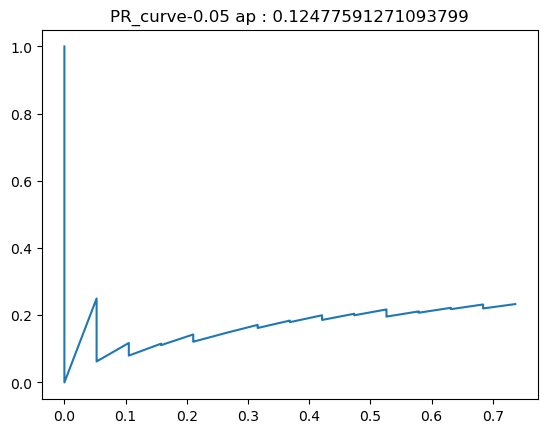

all_iou 4.507674358785152
mIOU 0.23724601888342908


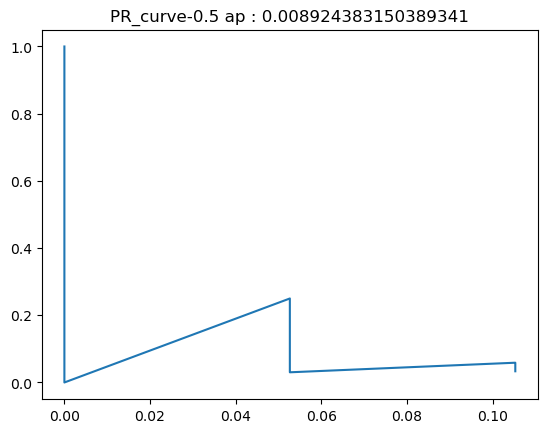

all_iou 4.507674358785152
mIOU 0.23724601888342908


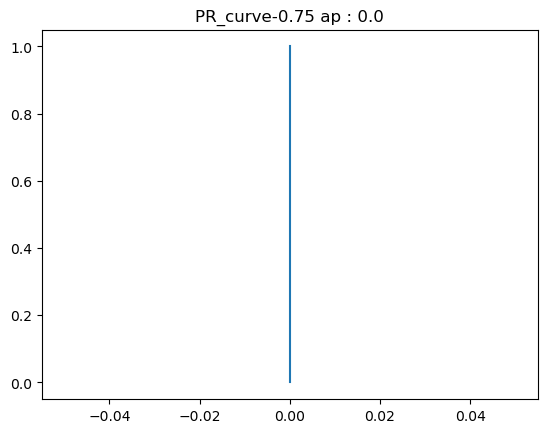

ep 10:   0%|          | 0/10 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ep 10:  10%|█         | 1/10 [00:00<00:07,  1.22it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ep 10:  20%|██        

=========== EVAL =========


ep 10:   0%|          | 0/5 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ep 10:  20%|██        | 1/5 [00:00<00:02,  1.84it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ep 10:  40%|████      | 

gt_count 19
all_prediction [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
recall [0.         0.         0.         0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.10526316 0.10526316
 0.10526316 0.10526316 0.10526316 0.10526316 0.10526316 0.10526316
 0.15789474 0.21052632 0.21052632 0.26315789 0.26315789 0.26315789
 0.26315789 0.26315789 0.26315789 0.31578947 0.31578947 0.36842105
 0.36842105 0.42105263 0.42105263 0.47368421 0.47368421 0.47368421
 0.47368421 0.52631579 0.52631579 0.57894737 0.57894737 0.57894737
 0.57894737 0.57894737 0.57894737 0.63157895 0.63157895 0.68421053
 0.68421053 0.73684211 0.73684211 0.73684211 0.73684211 0.73684211
 0.73684211]
precision [1.         0.         0.         0.33333333 0.25       0.2
 0.16666667 0.14285714 0.125 

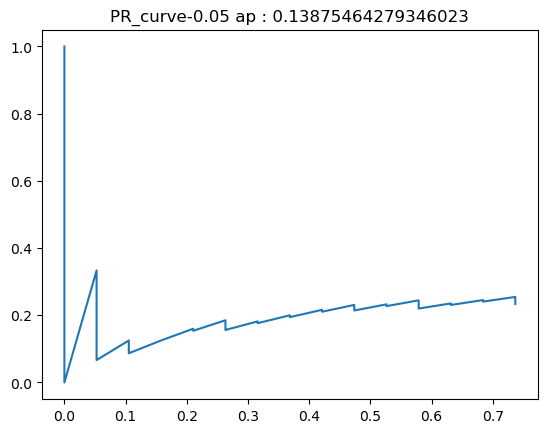

all_iou 4.494270650669932
mIOU 0.23654056056157538


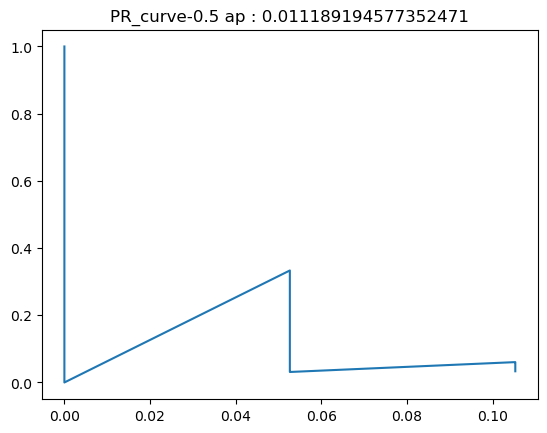

all_iou 4.494270650669932
mIOU 0.23654056056157538


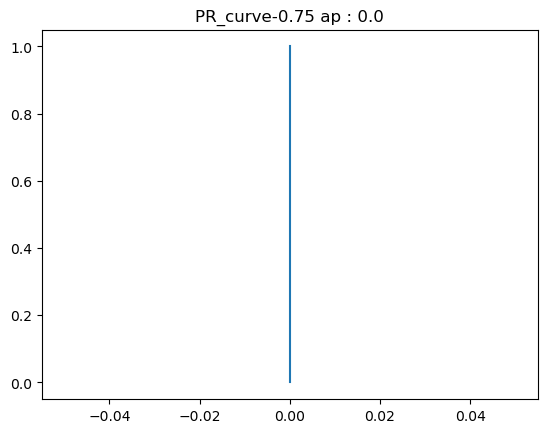

ep 11:  10%|█         | 1/10 [00:00<00:03,  2.39it/s]


KeyboardInterrupt: 

In [25]:
# Train / Eval
train_dataset = CustomDataset( f"{TRAIN_DATASET_NAME}" , use_aug = False  )  
eval_dataset = CustomDataset( f"{TEST_DATASET_NAME}"  ,  use_aug = False ) 

train_dataloader = DataLoader(train_dataset, BATCH_SIZE , shuffle=True, drop_last =True)
eval_dataloader = DataLoader(eval_dataset, BATCH_SIZE , shuffle=False, drop_last =True)

  
#ep_count = 1 if LOADED_EPOCH is None else LOADED_EPOCH+1
#train_loop()

#while True:
for i in range(51):        
    ep_count = i
    # ======= Train EPOCH =======    
    train_loop( dataloader= train_dataloader ,ep_count= i , log_folder= log_folder )    
    # ======= Eval EPOCH =======    
    if(ep_count % EVAL_GAP ==0):
        print("=========== EVAL =========")            
        with torch.no_grad():        
            auc = eval_loop(eval_dataloader,ep_count)
            
            if(auc > save_auc) :                    
                path = os.path.join(MODEL_FOLDER , f"{TRAIN_NAME}_bk_best_auc{auc}.pth")
                save_model(model, path , ep_count , auc)
                save_auc = auc
            if(ep_count % 5 == 0):
                #path = './output/'+ 'bk.pth'
                path = os.path.join(MODEL_FOLDER , f"{TRAIN_NAME}_bk.pth")
                save_model(model, path , ep_count , auc)
                
    #ep_count+=1

#save_model(net,f'./output/{TRAIN_NAME}-final.pth' , ep_count , save_auc )
'''
'''
